In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


! if [ ! -d /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/ ]; then mkdir /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis; fi

os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/')

## Copy Files

In [228]:
%%bash
# get differentially expressed gene files
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/homer_diffExpresion.tsv ./human_diffExpression.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/homer_diffExpresion.tsv ./mouse_diffExpression.tsv

# get IDR scores
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_Des_idrUnion.tsv ./mouse_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_DMHCA_idrUnion.tsv ./mouse_dmhca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_T09_idrUnion.tsv ./mouse_t09_idrUnion.tsv

cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_Des_idrUnion.tsv ./human_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_DMHCA_idrUnion.tsv ./human_dhmca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_T09_idrUnion.tsv ./human_t09_idrUnion.tsv

# get rpkm values
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/rpkm.tsv ./mouse_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/rpkm.tsv ./human_rpkm.tsv



## Identify mouse human homologs

In [275]:
# download homolog file
! wget ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt

--2016-08-01 09:56:57--  ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt
           => ‘HOM_MouseHumanSequence.rpt’
Resolving ftp.informatics.jax.org (ftp.informatics.jax.org)... 64.147.54.33
Connecting to ftp.informatics.jax.org (ftp.informatics.jax.org)|64.147.54.33|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/reports ... done.
==> SIZE HOM_MouseHumanSequence.rpt ... 7596152
==> PASV ... done.    ==> RETR HOM_MouseHumanSequence.rpt ... done.
Length: 7596152 (7.2M) (unauthoritative)

100%[======================================>] 7,596,152   4.04MB/s   in 1.8s   

2016-08-01 09:57:00 (4.04 MB/s) - ‘HOM_MouseHumanSequence.rpt’ saved [7596152]



In [276]:
homolog_frame = pd.read_csv('./HOM_MouseHumanSequence.rpt', sep='\t')

In [444]:
mouse_homolog_genes = set()
human_homolog_genes = set()
current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'mouse, laboratory']

homoloGeneID_mouseGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'human']

homoloGeneID_humanGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

mouse_human_homologMapping = {}
human_mouse_homologMapping = {}
count = 0
for key in homoloGeneID_humanGene_dict:
    if key in homoloGeneID_humanGene_dict and key in homoloGeneID_mouseGene_dict:
        mouse_gene = homoloGeneID_mouseGene_dict[key].upper()
        human_gene = homoloGeneID_humanGene_dict[key].upper()

        mouse_human_homologMapping[mouse_gene] = human_gene
        human_mouse_homologMapping[human_gene] = mouse_gene
        
        mouse_homolog_genes.add(mouse_gene)
        human_homolog_genes.add(human_gene)
    else:
        count+=1
print(count)

1951


## Integrate IDR Scores with EdgeR

In [393]:
condition_significantGenes_dict = {}
condition_significantFrame_dict = {}

In [445]:
### Read in EdgeR Values

# human
diffExpression_human_frame = pd.read_csv('human_diffExpression.tsv', sep='\t')
columns = diffExpression_human_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_human_frame.columns=columns
diffExpression_human_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_human_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_human_frame.columns if 'vs.' in x]
diffExpression_human_frame = diffExpression_human_frame[columns]
diffExpression_human_frame = diffExpression_human_frame[diffExpression_human_frame['gene'].isin(human_homolog_genes)]
diffExpression_human_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in diffExpression_human_frame['gene'].values]
diffExpression_human_frame.index = diffExpression_human_frame.gene.values


# mouse
diffExpression_mouse_frame = pd.read_csv('mouse_diffExpression.tsv', sep='\t')
columns = diffExpression_mouse_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_mouse_frame.columns=columns
diffExpression_mouse_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_mouse_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_mouse_frame.columns if 'vs.' in x]
diffExpression_mouse_frame = diffExpression_mouse_frame[columns]
diffExpression_mouse_frame = diffExpression_mouse_frame[diffExpression_mouse_frame['gene'].isin(mouse_homolog_genes)]
diffExpression_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in diffExpression_mouse_frame['gene'].values]
diffExpression_mouse_frame.index = diffExpression_mouse_frame.gene.values



In [446]:
### integrate mouse scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('mouse_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_mouse_frame[
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle adj. p-value'] < p_threshold) &
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle Log2 Fold Change'].abs() > fold_threshold) &
                            (diffExpression_mouse_frame.index.isin(idr_frame.index.values)) &
                            (diffExpression_mouse_frame.index.isin(human_homolog_genes))
                        ][['gene', 
                           treatment + ' vs. Vehicle adj. p-value', 
                           treatment + ' vs. Vehicle Log2 Fold Change']]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    down_frame.to_csv('mouse_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    up_frame.to_csv('mouse_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_up'] = up_frame.index.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [447]:
### integrate human scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('human_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_human_frame[
                            (diffExpression_human_frame[treatment + ' vs. Vehicle FDR'] < p_threshold) &
                            (diffExpression_human_frame[treatment + ' vs. Vehicle logFC'].abs() > fold_threshold) &
                            (diffExpression_human_frame.index.isin(idr_frame.index.values) &
                            (diffExpression_human_frame.index.isin(human_homolog_genes)))
                        ][['gene',
                           treatment + ' vs. Vehicle FDR', 
                           treatment + ' vs. Vehicle logFC']]
    
    significant_frame.columns = [x.replace('FDR', 'adj. p-value').replace('logFC', 'Log2 Fold Change')
                                 for x in significant_frame.columns.values]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    down_frame.to_csv('human_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    up_frame.to_csv('human_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_up'] = up_frame.index.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Comparisons

### Des

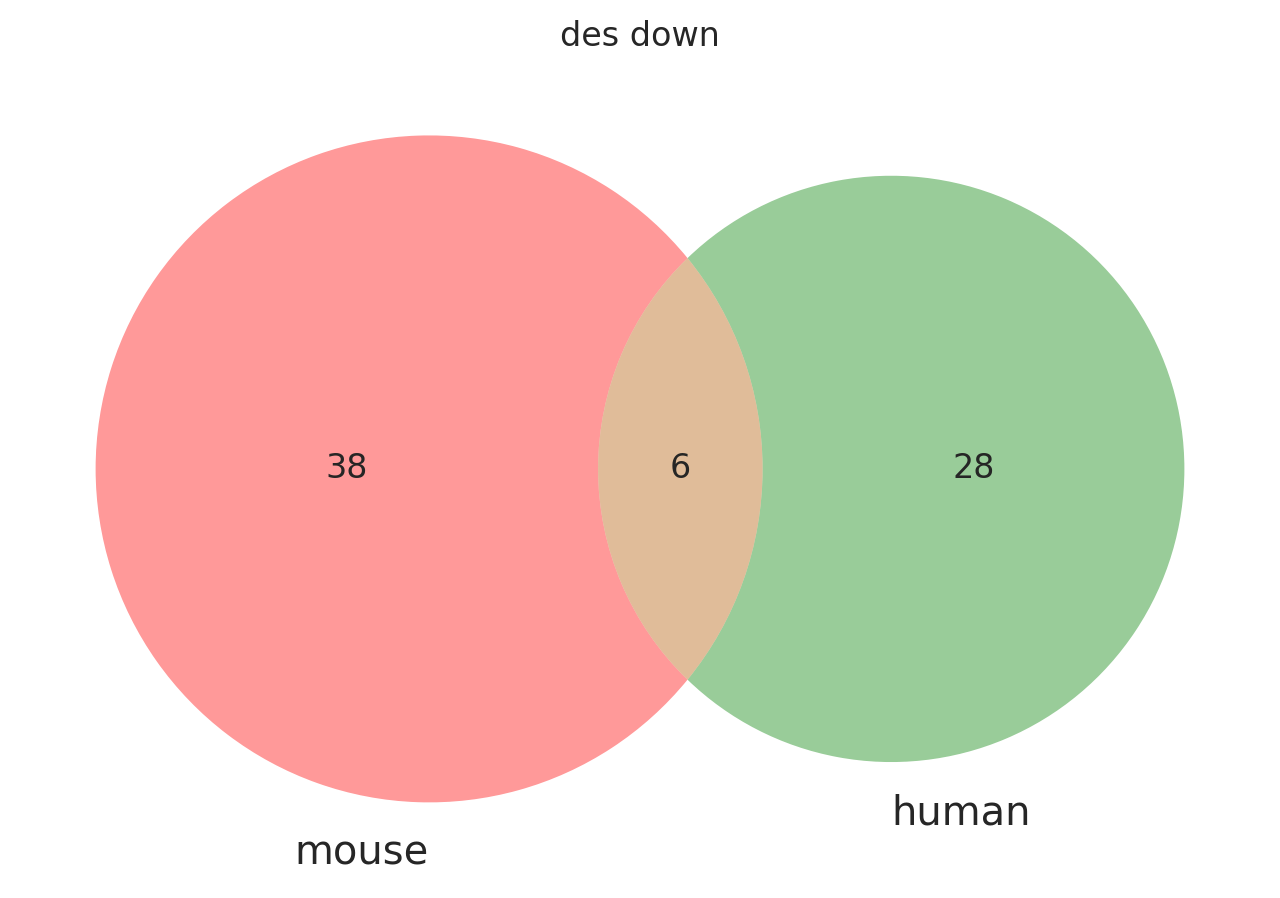

In [448]:
treatment = 'des'
direction = 'down'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')




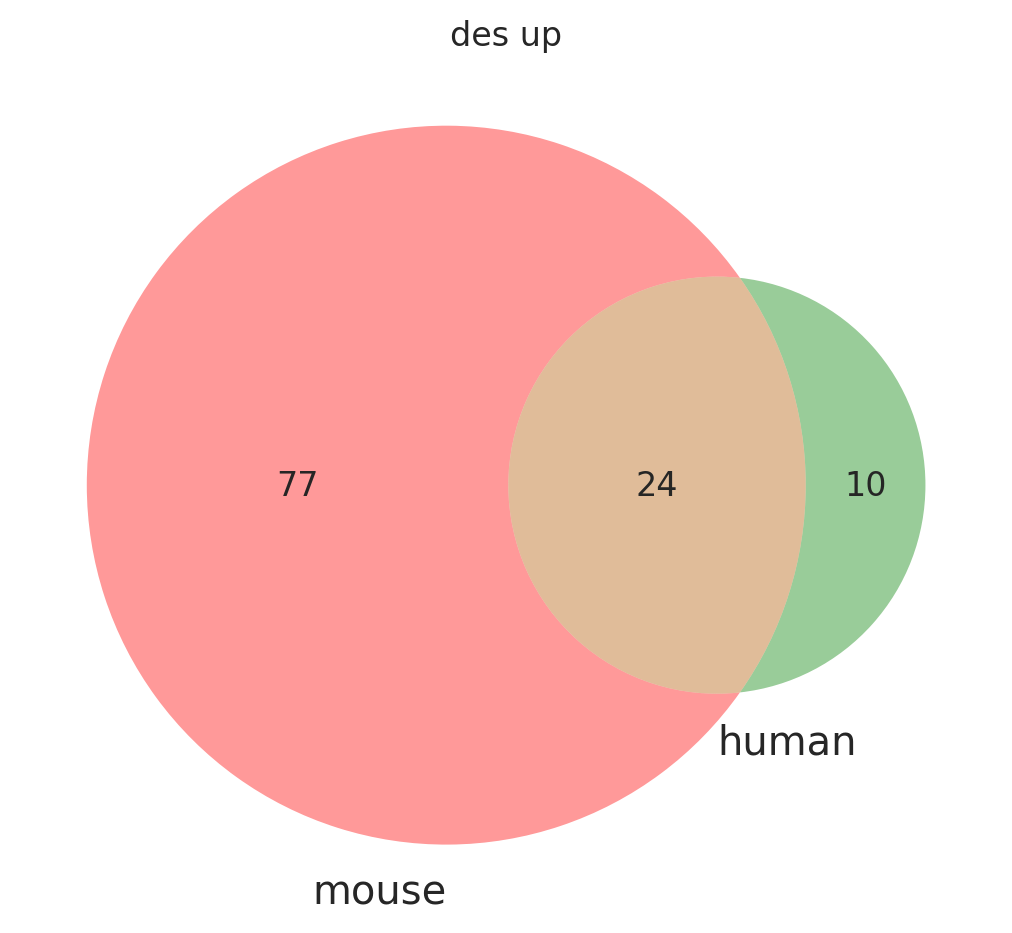

In [449]:
treatment = 'des'
direction = 'up'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')



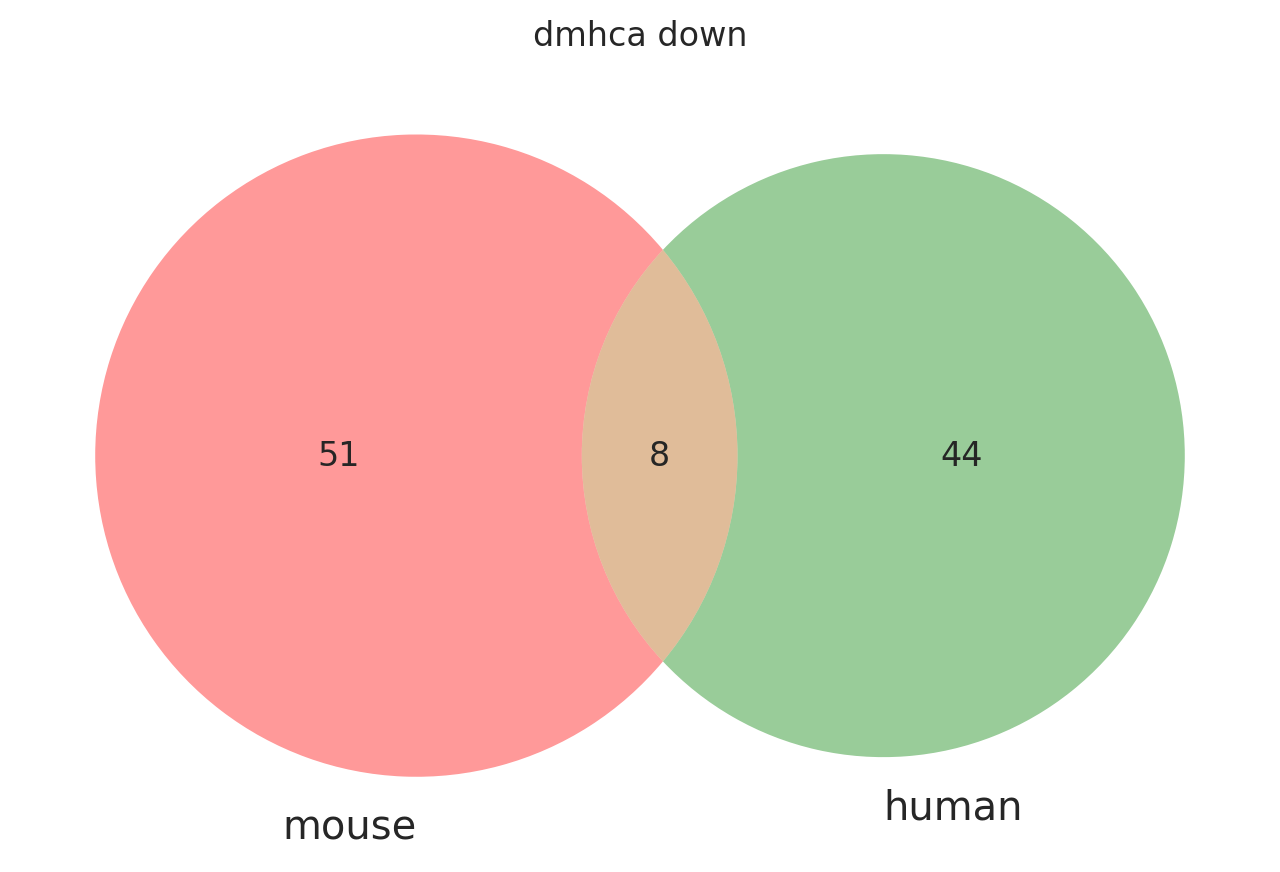

In [450]:
treatment = 'dmhca'
direction = 'down'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')


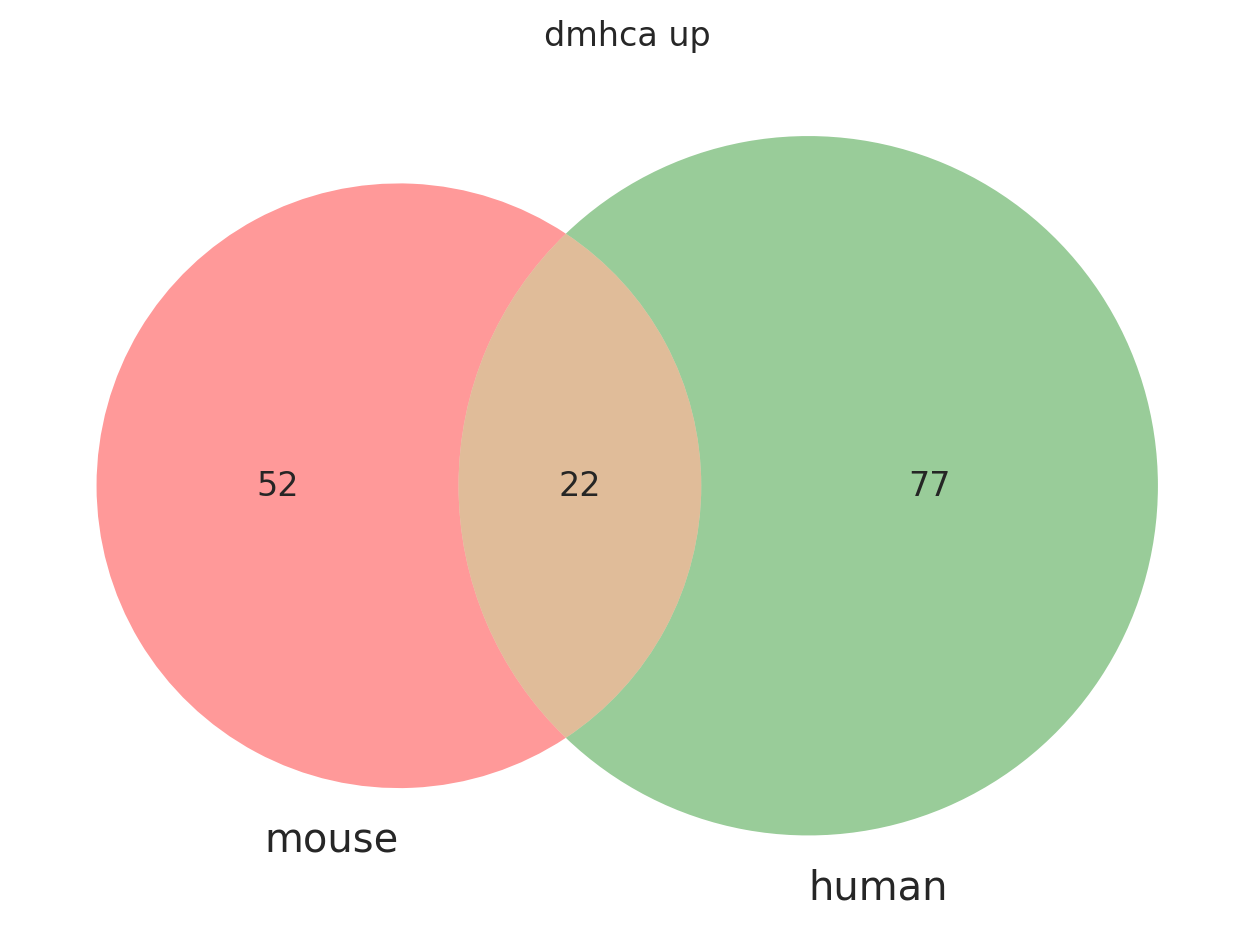

In [451]:
treatment = 'dmhca'
direction = 'up'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

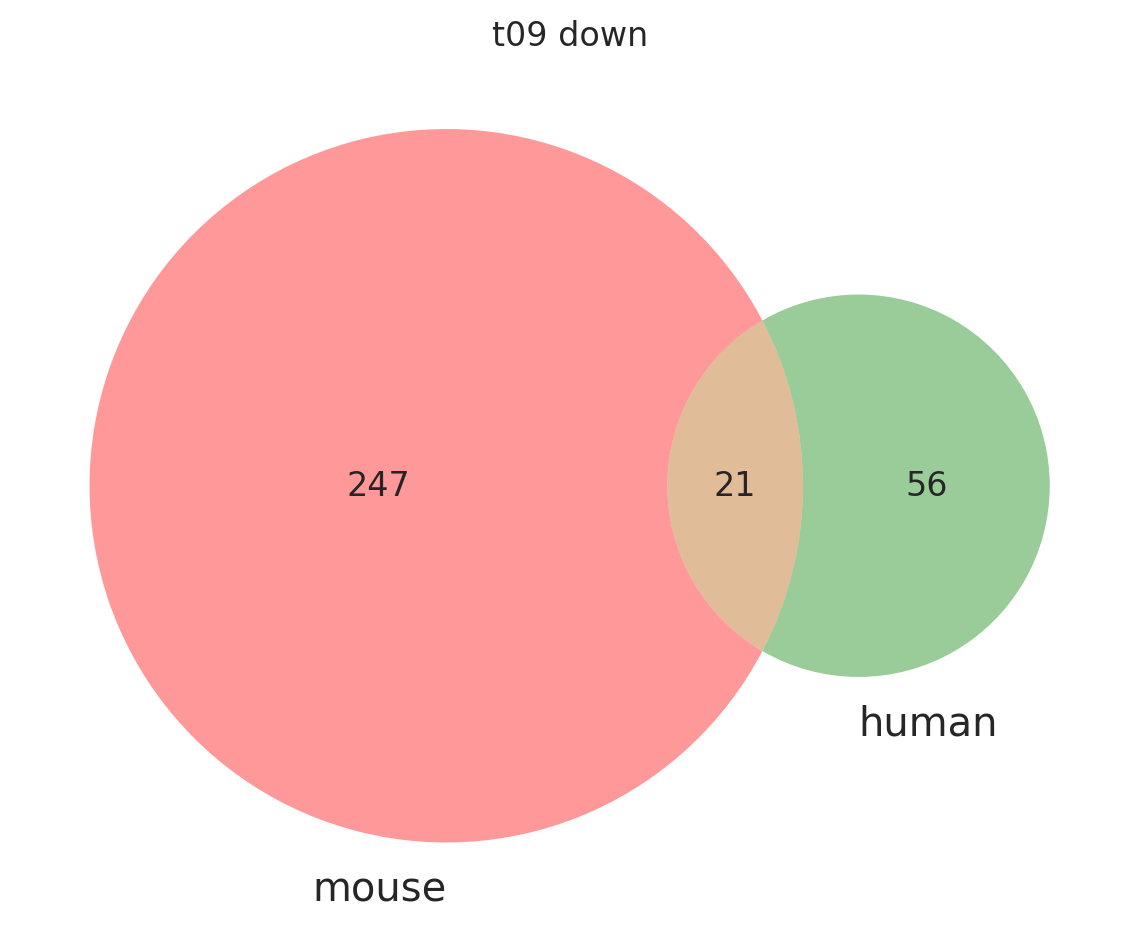

In [452]:
treatment = 't09'
direction = 'down'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')



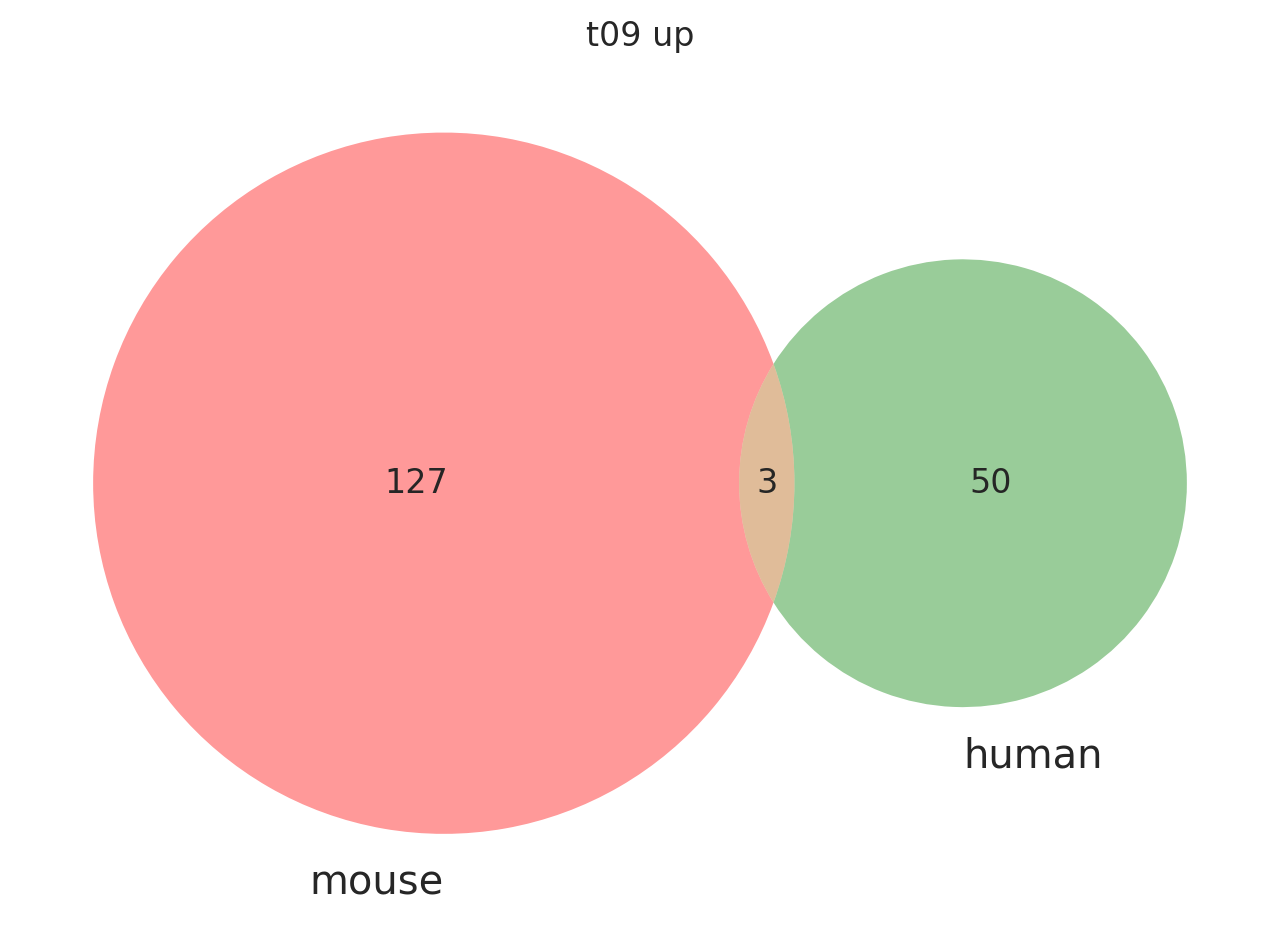

In [453]:
treatment = 't09'
direction = 'up'

gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]

mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')


## Variance Stuff

In [465]:
# read in human rpkm values
rpkm_human_frame = pd.read_csv('./human_rpkm.tsv', sep='\t')
columns = rpkm_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_human_frame.columns = columns    
rpkm_human_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_human_frame['Annotation/Divergence']]
columns = list(rpkm_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_human_frame = rpkm_human_frame[columns]
rpkm_human_frame = rpkm_human_frame[rpkm_human_frame['gene'].isin(human_homolog_genes)]
# rpkm_human_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping else
#                             human_mouse_homologMapping[x] if x in human_mouse_homologMapping else x
#                             for x in rpkm_human_frame['gene'].values]
rpkm_human_frame.index = rpkm_human_frame['gene'].values

In [473]:
# read in mouse rpkm values
rpkm_mouse_frame = pd.read_csv('./mouse_rpkm.tsv', sep='\t')
columns = rpkm_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_mouse_frame.columns = columns    
rpkm_mouse_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_mouse_frame['Annotation/Divergence']]
columns = list(rpkm_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_mouse_frame = rpkm_mouse_frame[columns]
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame['gene'].isin(human_homolog_genes)]
rpkm_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                            else x
                            for x in rpkm_mouse_frame['gene'].values]
rpkm_mouse_frame.index = rpkm_mouse_frame['gene'].values

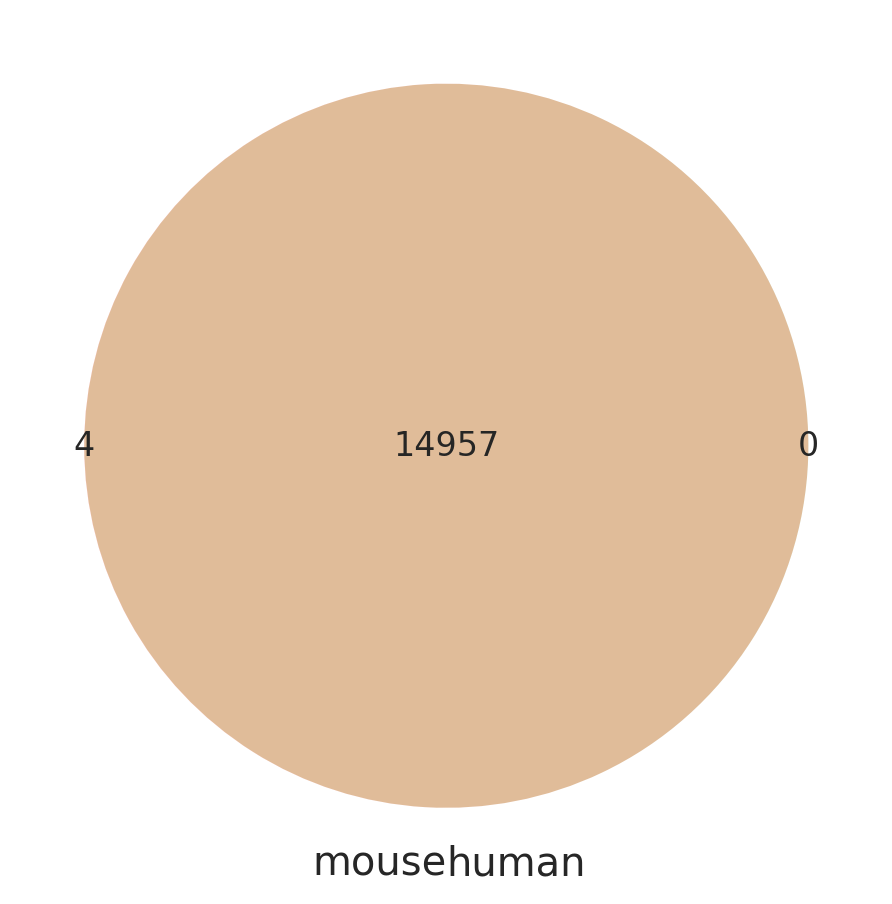

In [474]:
matplotlib_venn.venn2([set(rpkm_mouse_frame.index.values),
 set(rpkm_human_frame.index.values)],
 ['mouse', 'human'])

In [475]:
intersecting_genes = set(rpkm_mouse_frame.index.values).intersection(set(rpkm_human_frame.index.values))

In [476]:
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame.index.isin(intersecting_genes)]
rpkm_human_frame = rpkm_human_frame[rpkm_human_frame.index.isin(intersecting_genes)]

In [480]:
rpkm_mouse_frame.columns[9:]

Index(['ThioMac_RNA_DMHCA-1_EDM_15-07-16', 'ThioMac_RNA_DMHCA-2_EDM_15-07-16',
       'ThioMac_RNA_DMHCA-3_EDM_15-07-16', 'ThioMac_RNA_Des-1_EDM_15-07-16',
       'ThioMac_RNA_Des-2_EDM_15-07-16', 'ThioMac_RNA_Des-3_EDM_15-07-16',
       'ThioMac_RNA_GW-2_EDM_15-07-16', 'ThioMac_RNA_GW-3_EDM_15-07-16',
       'ThioMac_RNA_GW-1_EDM_15-07-16', 'ThioMac_RNA_Mepip-3_EDM_15-07-16',
       'ThioMac_RNA_Mepip-2_EDM_15-07-16', 'ThioMac_RNA_Mepip-1_EDM_15-07-16',
       'ThioMac_RNA_T09-2_EDM_15-07-16', 'ThioMac_RNA_T09-3_EDM_15-07-16',
       'ThioMac_RNA_T09-1_EDM_15-07-16', 'ThioMac_RNA_Vehicle-1_EDM_15-07-16',
       'ThioMac_RNA_Vehicle-3_EDM_15-07-16',
       'ThioMac_RNA_Vehicle-2_EDM_15-07-16'],
      dtype='object')

In [530]:
### match samples and treatments

# for humans
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_human_dict = {}
for sample in rpkm_human_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[0].split('-')[-1]
    treatment = tokens[2]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_human_dict:
        treatment_sample_human_dict[treatment].append(sample)
    else:
        treatment_sample_human_dict[treatment] = [sample]
        
treatment_sample_bool_human_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_human_dict[treatment].append(True)
        else:
            treatment_sample_bool_human_dict[treatment].append(False)
treatment_sample_human_frame = pd.DataFrame(treatment_sample_bool_human_dict, columns=sorted(treatments), index=sorted(sampleNames))

In [531]:
# for mouse
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_mouse_dict = {}
for sample in rpkm_mouse_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[2].split('-')[-1]
    treatment = tokens[2].split('-')[0]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_mouse_dict:
        treatment_sample_mouse_dict[treatment].append(sample)
    else:
        treatment_sample_mouse_dict[treatment] = [sample]
        
treatment_sample_bool_mouse_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_mouse_dict[treatment].append(True)
        else:
            treatment_sample_bool_mouse_dict[treatment].append(False)
treatment_sample_mouse_frame = pd.DataFrame(treatment_sample_bool_mouse_dict, columns=sorted(treatments), index=sorted(sampleNames))

In [532]:
treatment_sample_human_frame

,DMHCA,Des,GW,Mepip,T09,Vehicle
006,True,True,False,True,True,True
008,False,True,True,True,True,True
012,True,True,True,False,True,True
013,True,False,True,True,True,True
015,True,True,False,True,True,True
021,True,True,True,False,True,True
024,True,True,True,True,True,False
038,True,True,True,True,True,True


In [533]:
treatment_sample_mouse_frame

,DMHCA,Des,GW,Mepip,T09,Vehicle
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True


In [547]:
def calcMAD(vals):
    '''
    inputs: an array of scalars
    output: median absolute deviation of input array
    Calculates MAD, the median of the absolute values 
    of the differences between the data values and the 
    overall median of the data set
    '''
    overall_median = np.median(vals)
    absolute_distances = [abs(x-overall_median) for x in vals]
    mad = np.median(absolute_distances)
    return mad

In [555]:
### calculate median absolute deviation
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    human_samples = treatment_sample_human_dict[treatment]
    current_human_frame = rpkm_human_frame.ix[:, human_samples]
    
    mouse_samples = treatment_sample_mouse_dict[treatment]
    current_mouse_frame = rpkm_mouse_frame.ix[:, mouse_samples]
    
    current_human_mads = []
    current_mouse_mads = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene, :].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_mad = calcMAD(human_vals)
        mouse_mad = calcMAD(mouse_vals)
        
        current_human_mads.append(human_mad)
        current_mouse_mads.append(mouse_mad)
        
    column_vals_dict[treatment + ' human MAD'] = current_human_mads
    column_vals_dict[treatment + ' mouse MAD'] = current_mouse_mads

# create data frame
mad_frame = pd.DataFrame(column_vals_dict)
mad_frame.index = mad_frame['gene'].values
del mad_frame['gene']
mad_frame = mad_frame[sorted(mad_frame.columns.values)]

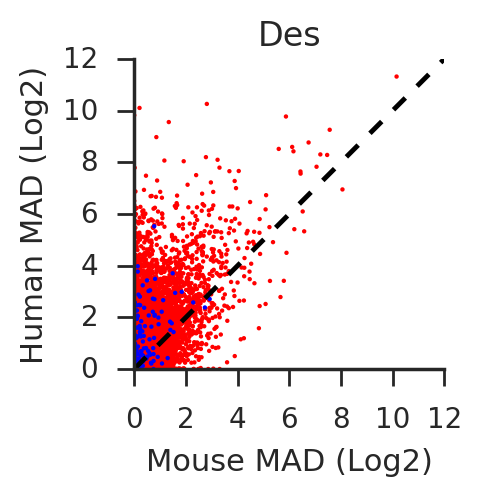

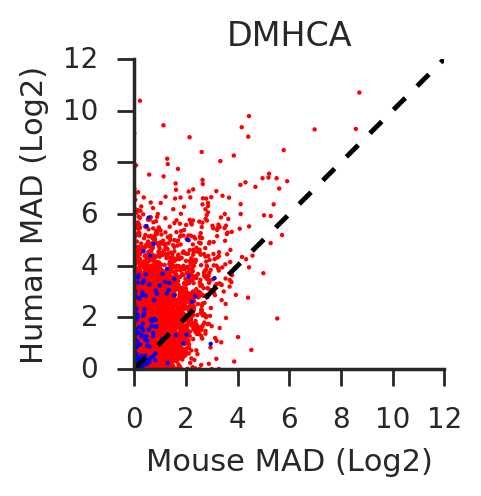

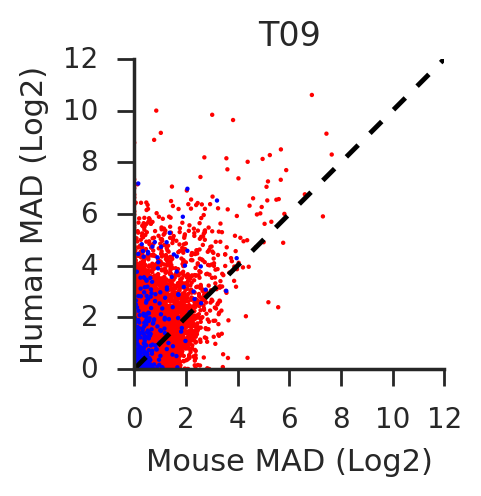

In [606]:
genes = mad_frame.index.values
for treatment in ['Des', 'DMHCA', 'T09']:
    human_mads = mad_frame[treatment + ' human MAD'].values
    mouse_mads = mad_frame[treatment + ' mouse MAD'].values
    
    up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
    down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
    diff_genes = set(up_genes).union(down_genes)
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    tuples = zip(genes, human_mads, mouse_mads, colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[3], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_colors = [x[3] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        plt.figure(figsize=(2,2))
        plt.scatter(np.log2(sorted_mouse_mads + 1), np.log2(sorted_human_mads+1),
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([0,12], [0,12], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((0,12))
        ax.set_ylim((0,12))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment)
        plt.xlabel('Mouse MAD (Log2)')
        plt.ylabel('Human MAD (Log2)')
        
        sns.despine()
        plt.show()

In [ ]:
set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]